## 1. Importing required libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

2023-11-29 18:38:18.880782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:38:18.913547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:38:18.914119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 18:38:19.449219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2. Loading the dataset

In [2]:
train_images_folder = "./dataset/train/images"
test_images_folder = "./dataset/test/images"

train_annotations_folder = "./dataset/train/annotations"
test_annotations_folder = "./dataset/test/annotations"


In [3]:
m_train = len(os.listdir(train_images_folder))
m_test = len(os.listdir(test_images_folder))

max_train_images_per_class = 2400
max_test_images_per_class = 400

# reading an image to figure out the dimensions 
img = cv2.imread(f"./dataset/train/images/0.png", cv2.IMREAD_GRAYSCALE)

h,w = img.shape

# Preallocate memory for the images and labels
train_images = np.empty((max_train_images_per_class * 10, h, w), dtype=np.float32)
train_labels = np.empty((max_train_images_per_class * 10, 4), dtype=np.int32)
test_images = np.empty((max_test_images_per_class * 10, h, w), dtype=np.float32)
test_labels = np.empty((max_test_images_per_class * 10, 4), dtype=np.int32)

print(f"Train data size: {max_train_images_per_class * 10}  |  Test data size: {max_test_images_per_class * 10}")

class_counts = {}

train_count = 0
# loading the train data (taking only 3000 images per class)
for i in range(m_train):
    
    if train_count == max_train_images_per_class * 10:
        print(f'Loaded {max_train_images_per_class} train images per class')
        break
    
    # reading the annotation to get labels
    with open(f"./dataset/train/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))

    
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_train_images_per_class:

        # reading the image
        img = cv2.imread(f"./dataset/train/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image
        train_images[train_count] = img / 255
        
        # storing the bbox coordinates
        train_labels[train_count] =  np.array([x_min , y_min , x_max , y_max]) 

        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        train_count += 1


class_counts = {}

test_count = 0
# loading the test data (taking only 500 images per class)
for i in range(m_test):

    if test_count == max_test_images_per_class * 10:
        print(f'Loaded {max_test_images_per_class} test images per class')
        break
        
    # reading the annotation to get labels
    with open(f"./dataset/test/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))
        
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_test_images_per_class:
        
        # reading the image
        img = cv2.imread(f"./dataset/test/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image
        test_images[test_count] = img / 255
        
        # storing the bbox coordinates
        test_labels[test_count] = np.array([x_min , y_min , x_max , y_max])
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        test_count += 1



Train data size: 24000  |  Test data size: 4000
Loaded 2400 train images per class
Loaded 400 test images per class


In [4]:
# renaming our arrays
train_x = train_images
train_y = train_labels
test_x = test_images
test_y = test_labels

print(f" train_x shape: {train_x.shape} \n train_y shape: {train_y.shape} \n test_x shape: {test_x.shape} \n test_y shape: {test_y.shape}")

 train_x shape: (24000, 75, 75) 
 train_y shape: (24000, 4) 
 test_x shape: (4000, 75, 75) 
 test_y shape: (4000, 4)


### Reshaping our data for vectorized implementation 

In [5]:
# reshaping
train_x = train_x.reshape(train_x.shape[0],-1).T
test_x = test_x.reshape(test_x.shape[0],-1).T
train_y = train_y.T
test_y = test_y.T

print(f'Shape of train_X: {train_x.shape}')
print(f'Shape of train_Y: {train_y.shape}')
print(f'Shape of test_X: {test_x.shape}')
print(f'Shape of test_Y: {test_y.shape}')

Shape of train_X: (5625, 24000)
Shape of train_Y: (4, 24000)
Shape of test_X: (5625, 4000)
Shape of test_Y: (4, 4000)


#### Displaying a random picture from our dataset to see if we have reshaped correctly

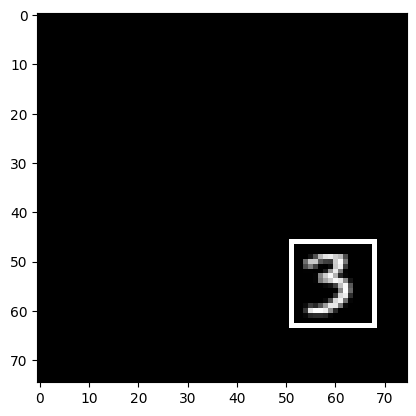

In [6]:
ind = 10000

img = (train_x[:,ind]*255).reshape(h,w)

xmin,ymin,xmax,ymax = train_y[:,ind]

bbox = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)

plt.imshow(bbox , cmap='gray')


# 3. Coding our Network

In [7]:
# Define the architecture of the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(5625,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu')
])

# Compile the model with MSE loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Transpose the labels to match the shape [num_examples, num_classes]
train_y = train_y.T
test_y = test_y.T
train_x = train_x.T
test_x = test_x.T

# Train the model
history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=2)
print('\nTest accuracy:', test_acc)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                56260     
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 56414 (220.37 KB)
Trainable params: 56414 (220.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-11-29 18:38:22.743842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 18:38:22.747716: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100


2023-11-29 18:38:22.981601: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 540000000 exceeds 10% of free system memory.


750/750 [==============================] - 2s 2ms/step - loss: 180.7130 - accuracy: 0.9017 - val_loss: 25.7526 - val_accuracy: 0.9433
Epoch 2/100
750/750 [==============================] - 1s 1ms/step - loss: 17.8972 - accuracy: 0.9528 - val_loss: 14.6149 - val_accuracy: 0.9507
Epoch 3/100
750/750 [==============================] - 1s 1ms/step - loss: 10.9690 - accuracy: 0.9611 - val_loss: 9.1741 - val_accuracy: 0.9688
Epoch 4/100
750/750 [==============================] - 1s 1ms/step - loss: 8.3445 - accuracy: 0.9650 - val_loss: 8.9278 - val_accuracy: 0.9668
Epoch 5/100
750/750 [==============================] - 1s 1ms/step - loss: 7.3990 - accuracy: 0.9698 - val_loss: 8.3129 - val_accuracy: 0.9660
Epoch 6/100
750/750 [==============================] - 1s 1ms/step - loss: 6.5834 - accuracy: 0.9711 - val_loss: 7.7464 - val_accuracy: 0.9705
Epoch 7/100
750/750 [==============================] - 1s 1ms/step - loss: 6.1867 - accuracy: 0.9698 - val_loss: 7.5295 - val_accuracy: 0.9695
Epoch

1/1 [==============================] - 0s 12ms/step


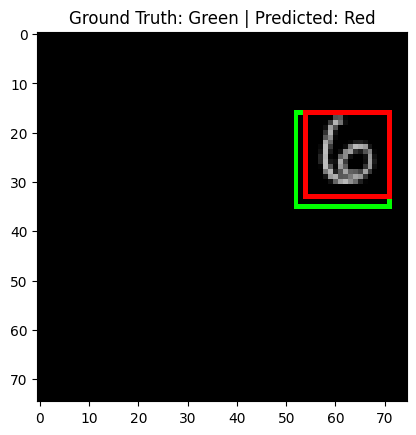

1/1 [==============================] - 0s 12ms/step


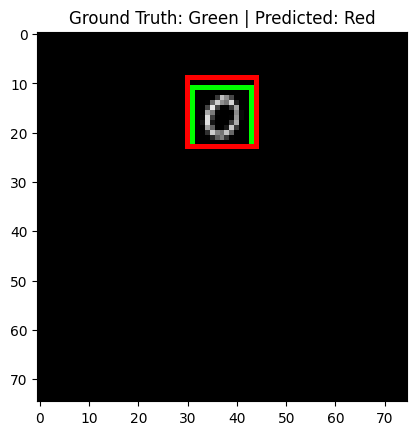

1/1 [==============================] - 0s 11ms/step


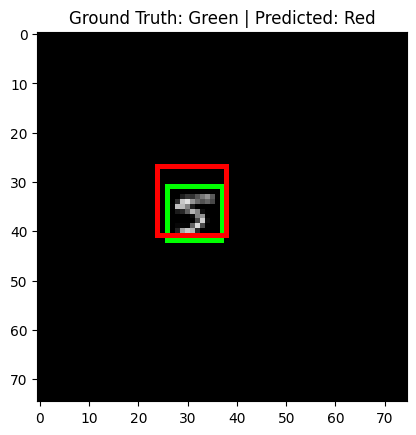

1/1 [==============================] - 0s 12ms/step


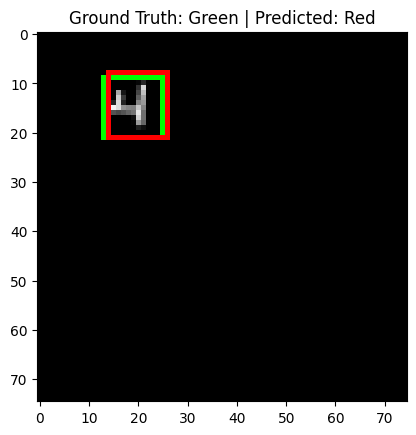

1/1 [==============================] - 0s 13ms/step


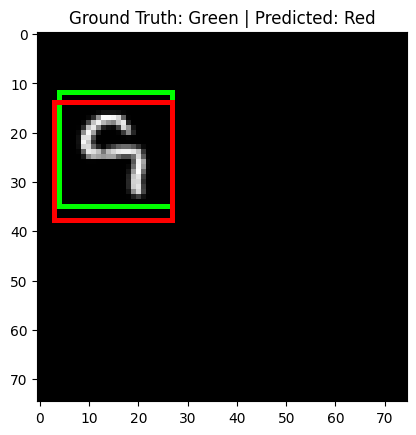

1/1 [==============================] - 0s 14ms/step


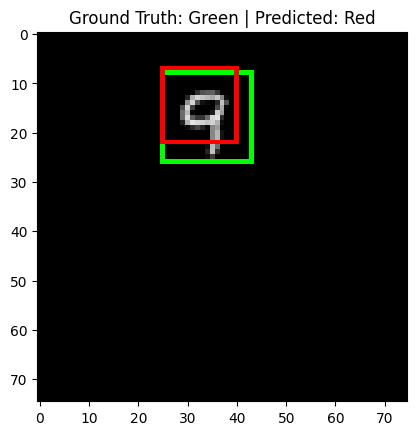

1/1 [==============================] - 0s 13ms/step


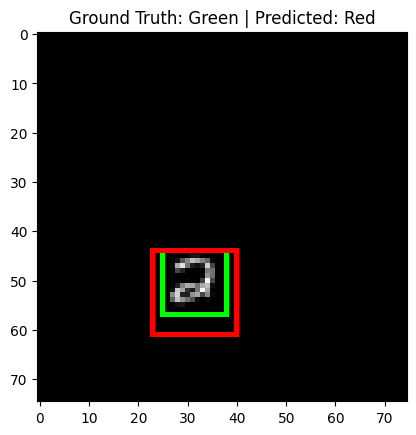

1/1 [==============================] - 0s 13ms/step


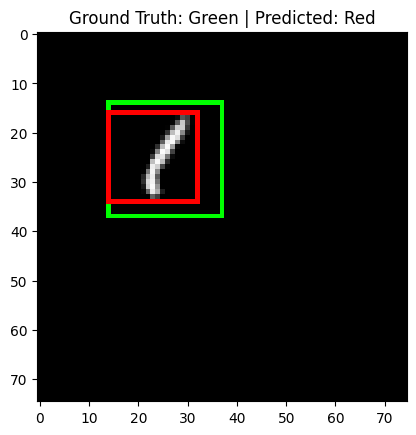

1/1 [==============================] - 0s 14ms/step


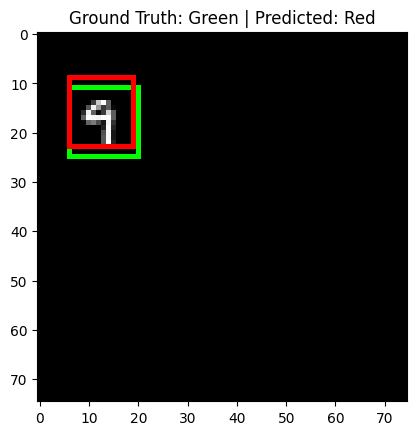

1/1 [==============================] - 0s 14ms/step


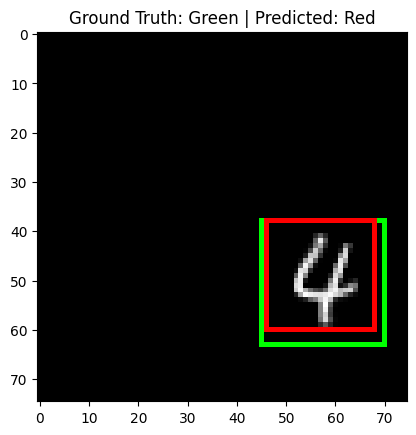

1/1 [==============================] - 0s 12ms/step


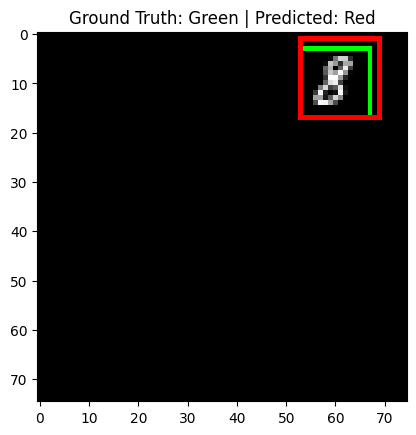

1/1 [==============================] - 0s 12ms/step


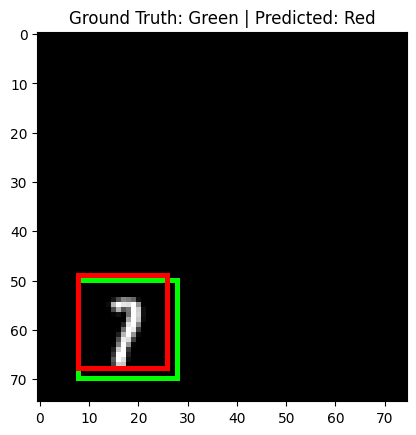

1/1 [==============================] - 0s 13ms/step


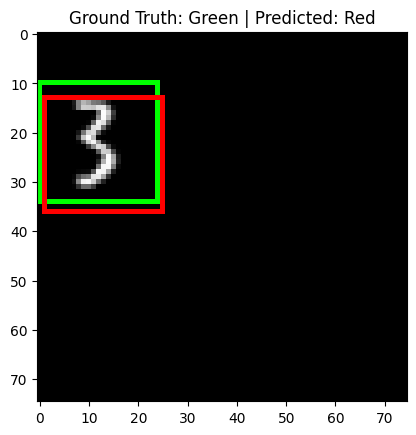

1/1 [==============================] - 0s 13ms/step


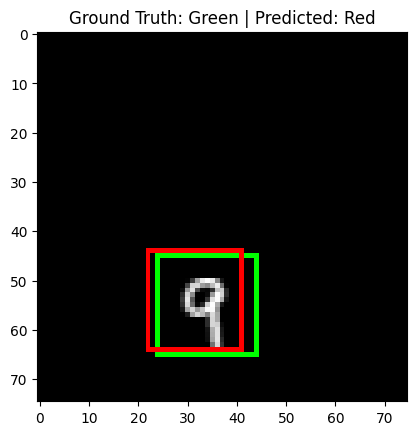

1/1 [==============================] - 0s 12ms/step


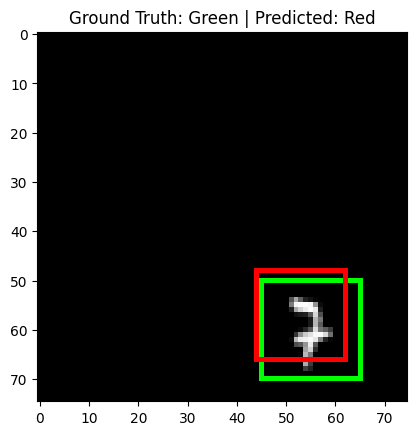

1/1 [==============================] - 0s 12ms/step


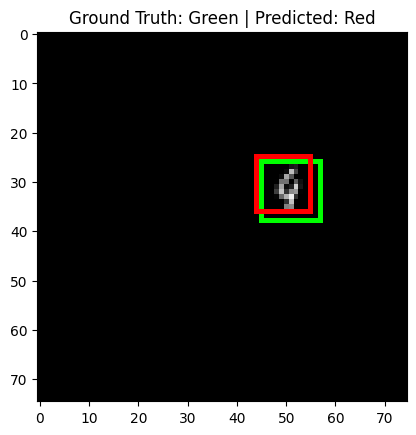

1/1 [==============================] - 0s 12ms/step


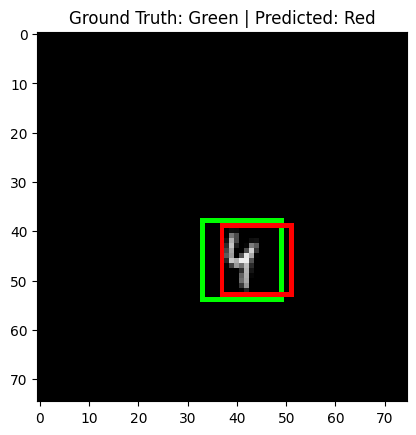

1/1 [==============================] - 0s 12ms/step


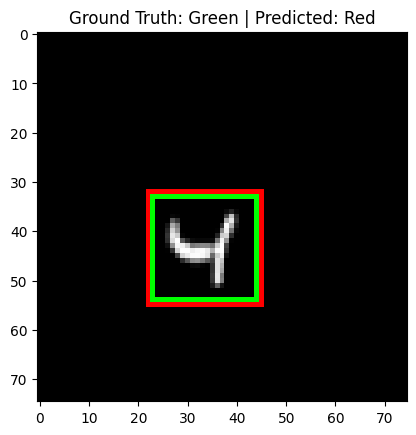

1/1 [==============================] - 0s 12ms/step


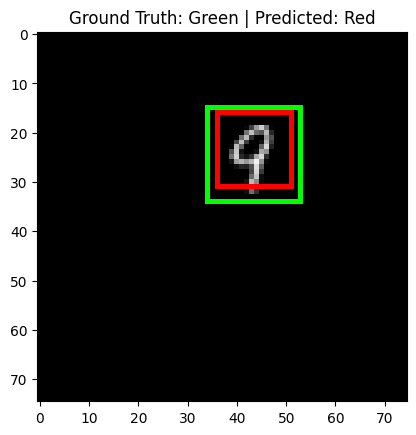

1/1 [==============================] - 0s 11ms/step


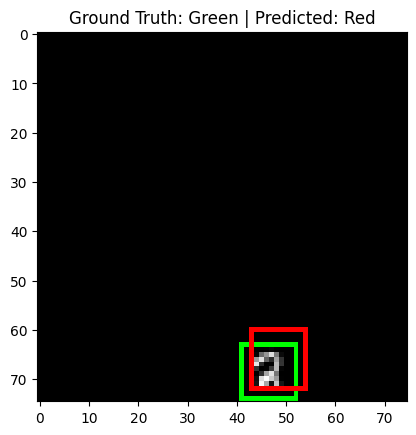

1/1 [==============================] - 0s 12ms/step


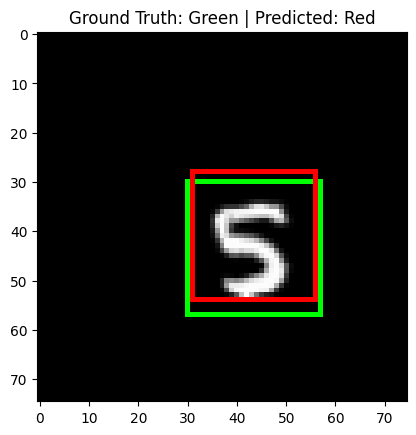

1/1 [==============================] - 0s 12ms/step


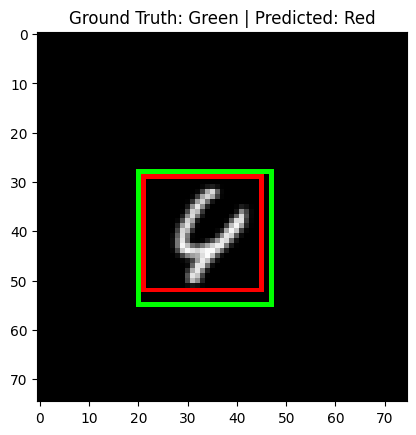

1/1 [==============================] - 0s 12ms/step


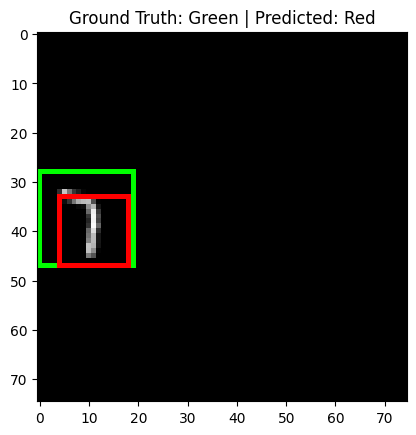

1/1 [==============================] - 0s 12ms/step


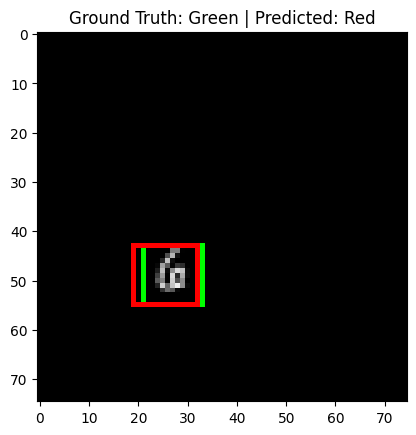

1/1 [==============================] - 0s 13ms/step


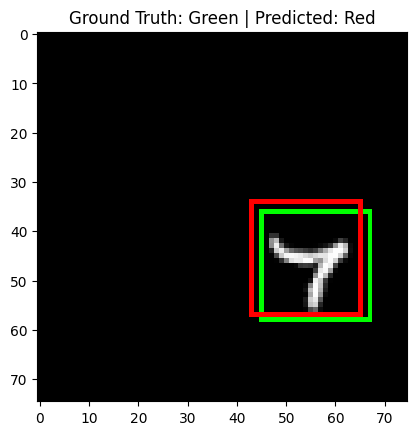

1/1 [==============================] - 0s 12ms/step


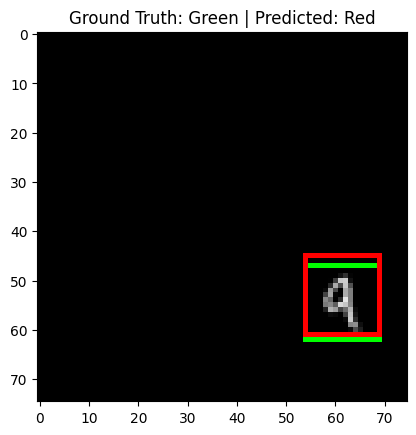

1/1 [==============================] - 0s 12ms/step


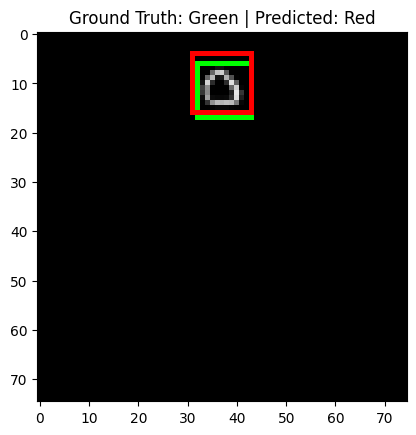

1/1 [==============================] - 0s 12ms/step


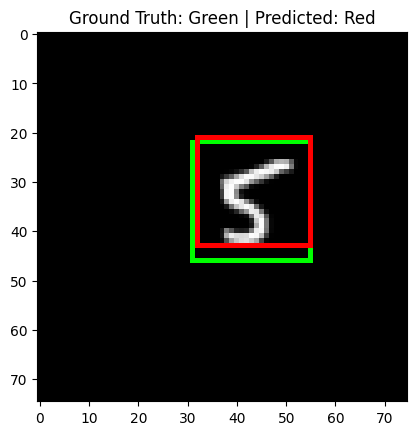

1/1 [==============================] - 0s 12ms/step


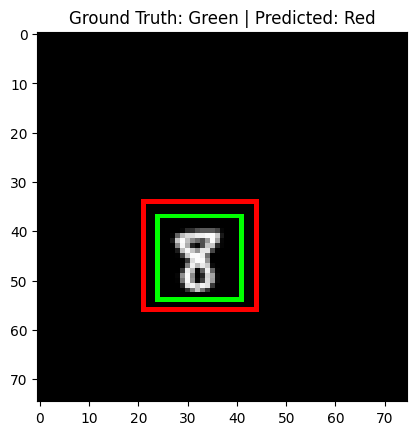

1/1 [==============================] - 0s 12ms/step


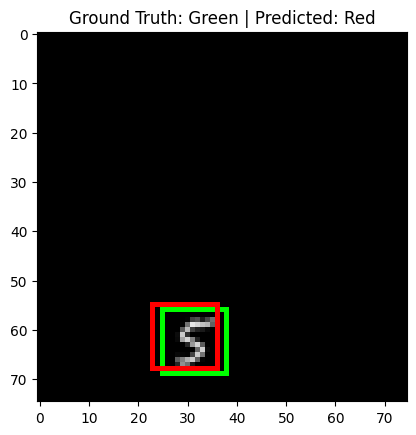

1/1 [==============================] - 0s 12ms/step


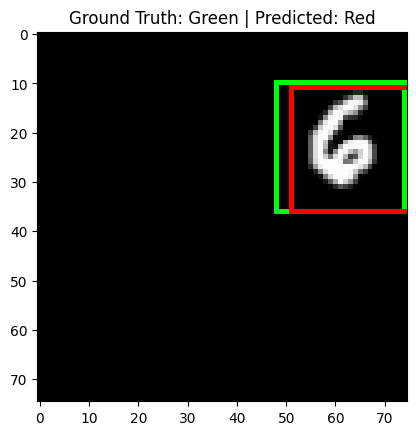

1/1 [==============================] - 0s 11ms/step


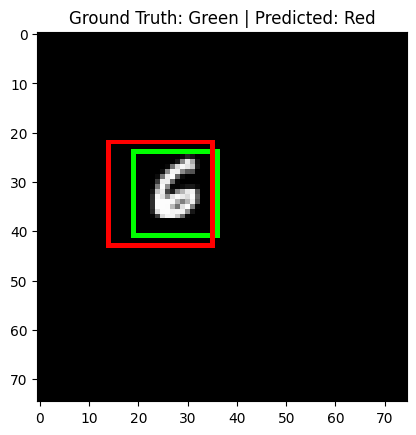

1/1 [==============================] - 0s 13ms/step


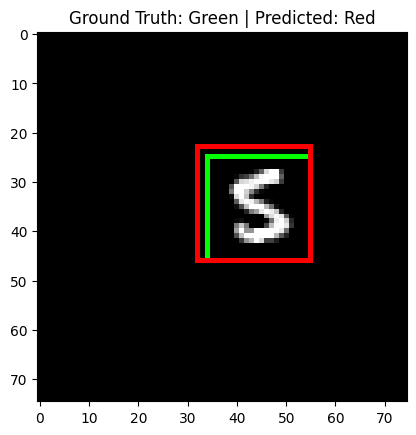

1/1 [==============================] - 0s 12ms/step


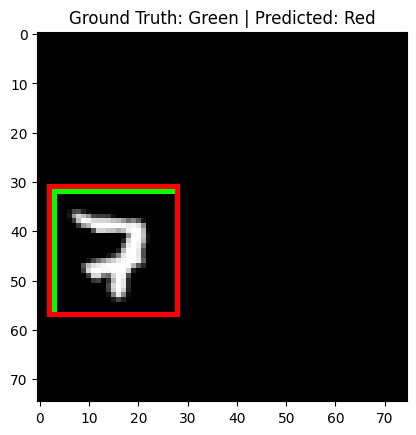

1/1 [==============================] - 0s 11ms/step


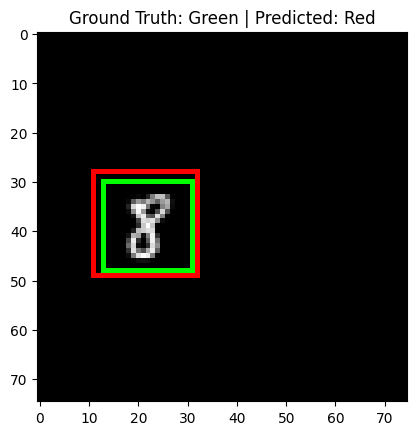

1/1 [==============================] - 0s 12ms/step


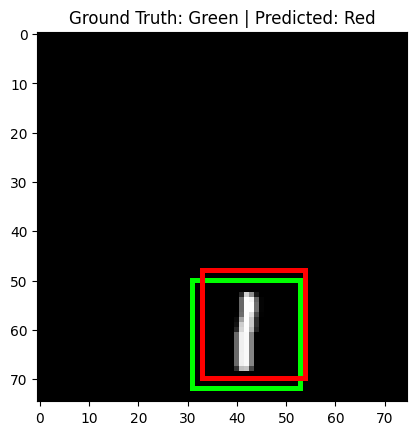

1/1 [==============================] - 0s 12ms/step


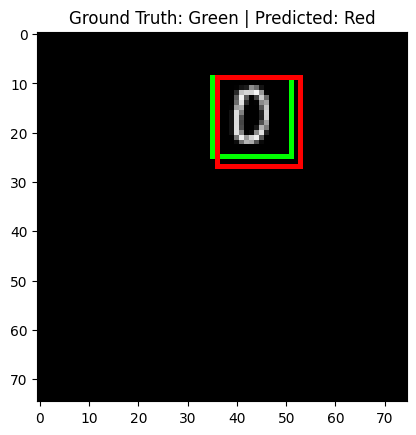

1/1 [==============================] - 0s 12ms/step


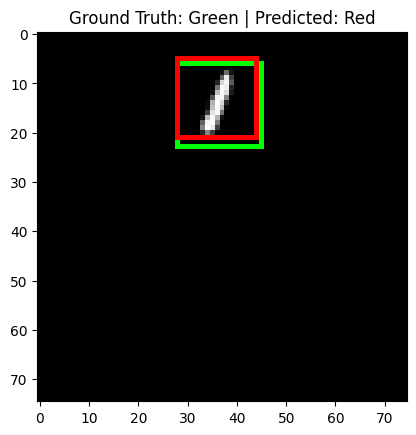

1/1 [==============================] - 0s 13ms/step


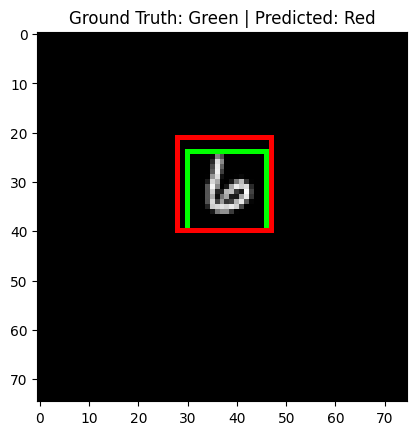

1/1 [==============================] - 0s 12ms/step


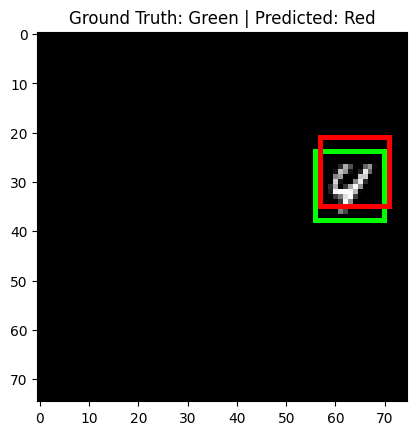

1/1 [==============================] - 0s 13ms/step


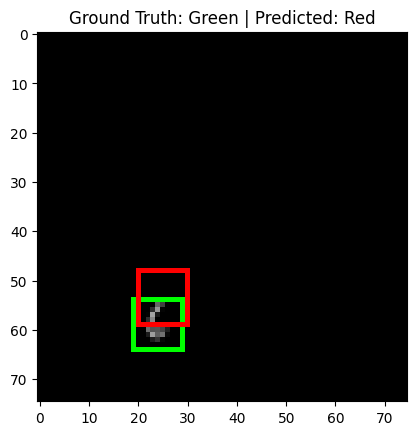

1/1 [==============================] - 0s 12ms/step


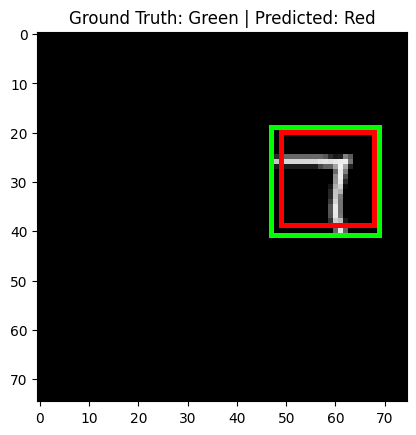

1/1 [==============================] - 0s 11ms/step


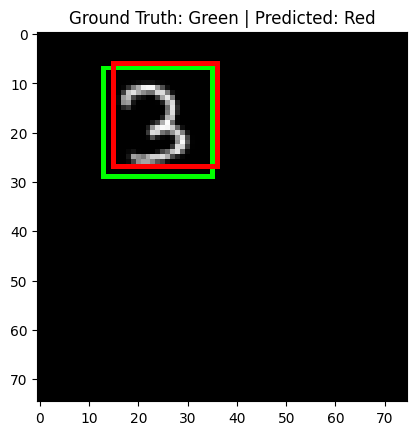

1/1 [==============================] - 0s 12ms/step


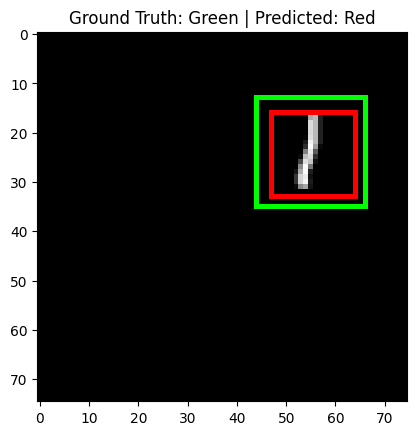

1/1 [==============================] - 0s 13ms/step


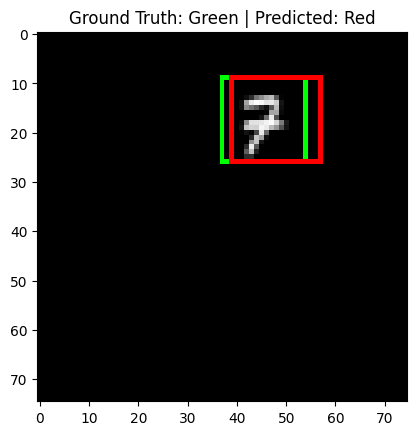

1/1 [==============================] - 0s 12ms/step


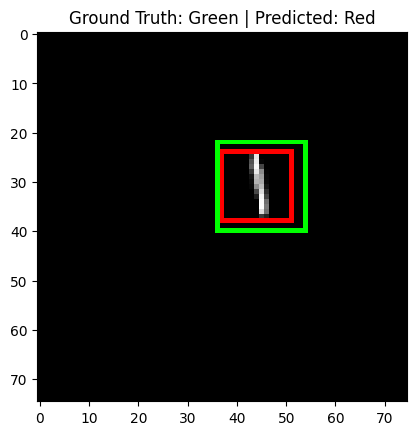

1/1 [==============================] - 0s 12ms/step


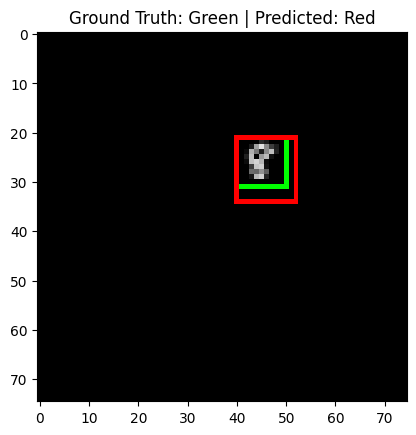

1/1 [==============================] - 0s 13ms/step


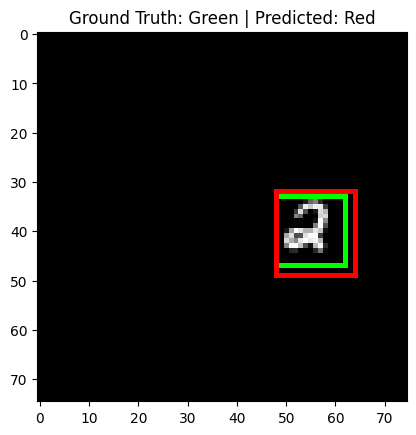

1/1 [==============================] - 0s 13ms/step


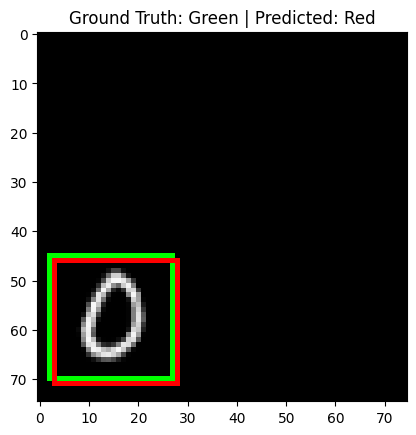

1/1 [==============================] - 0s 12ms/step


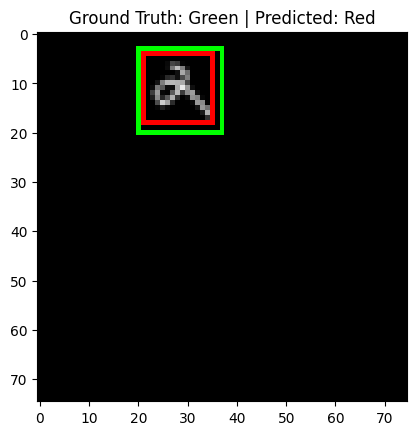

1/1 [==============================] - 0s 12ms/step


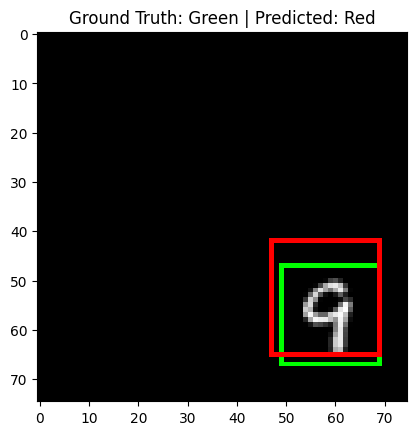

1/1 [==============================] - 0s 11ms/step


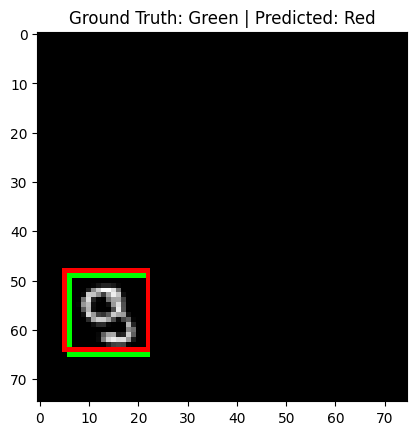

1/1 [==============================] - 0s 11ms/step


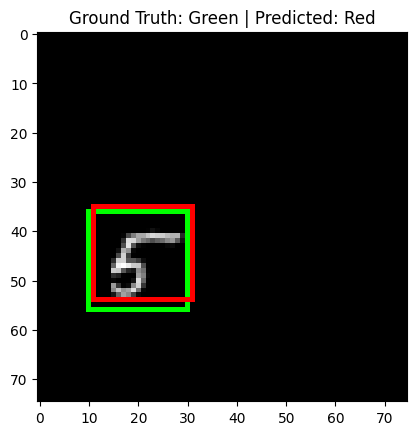

1/1 [==============================] - 0s 11ms/step


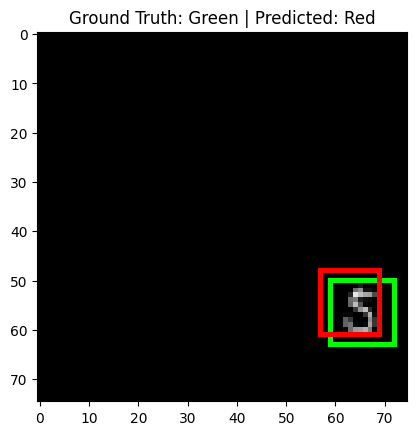

1/1 [==============================] - 0s 12ms/step


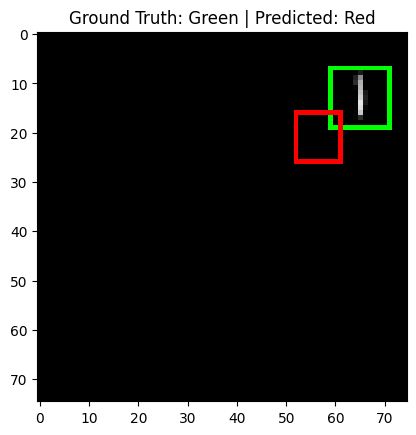

1/1 [==============================] - 0s 12ms/step


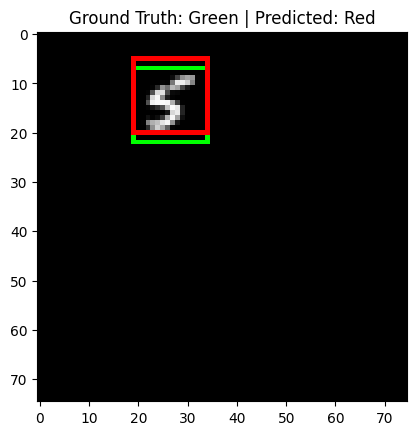

1/1 [==============================] - 0s 12ms/step


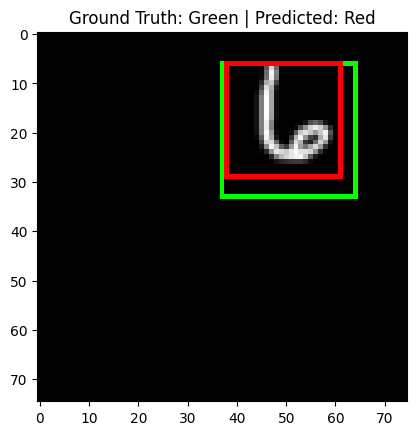

1/1 [==============================] - 0s 11ms/step


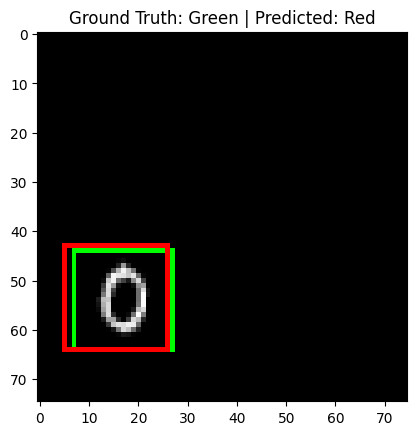

1/1 [==============================] - 0s 12ms/step


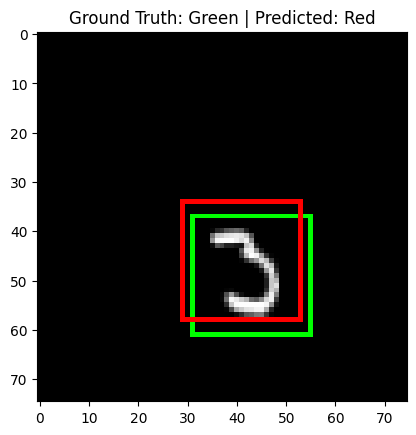

1/1 [==============================] - 0s 11ms/step


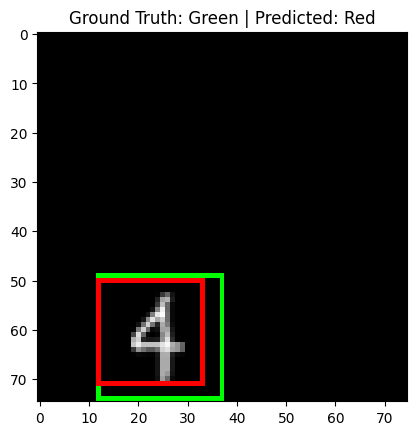

1/1 [==============================] - 0s 11ms/step


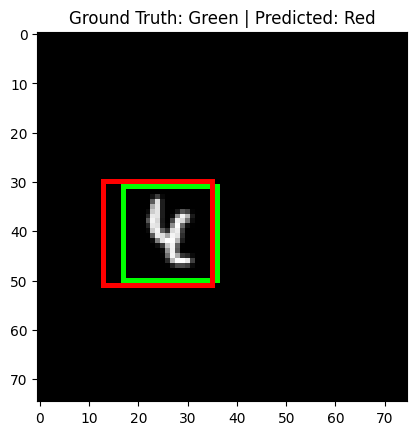

1/1 [==============================] - 0s 11ms/step


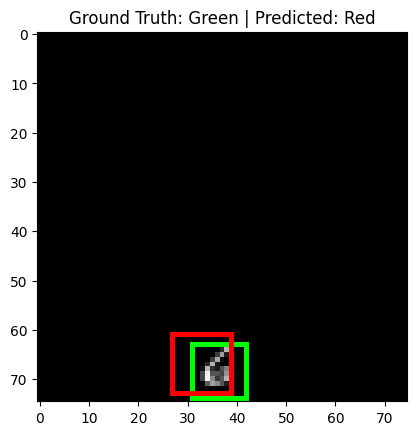

1/1 [==============================] - 0s 12ms/step


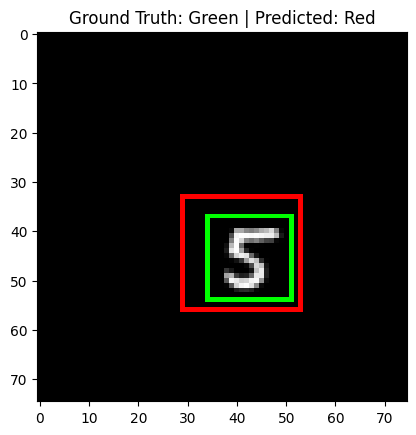

1/1 [==============================] - 0s 12ms/step


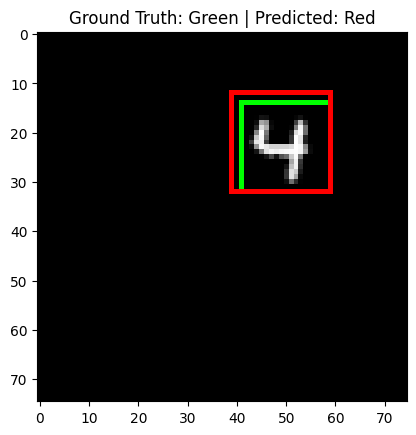

1/1 [==============================] - 0s 12ms/step


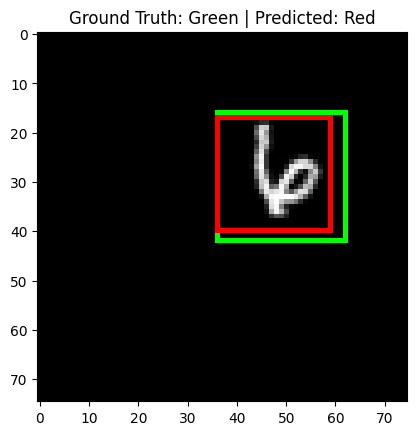

1/1 [==============================] - 0s 12ms/step


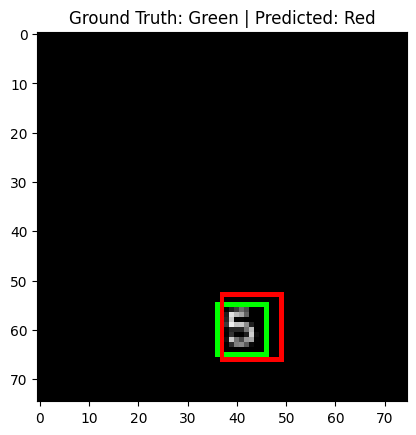

1/1 [==============================] - 0s 11ms/step


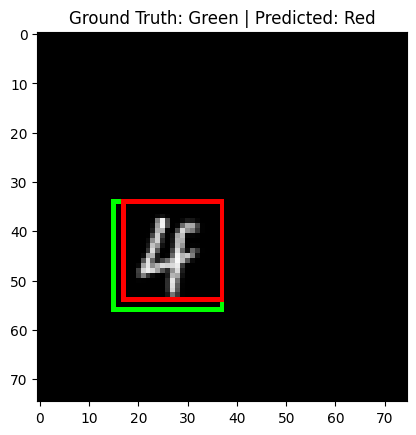

1/1 [==============================] - 0s 11ms/step


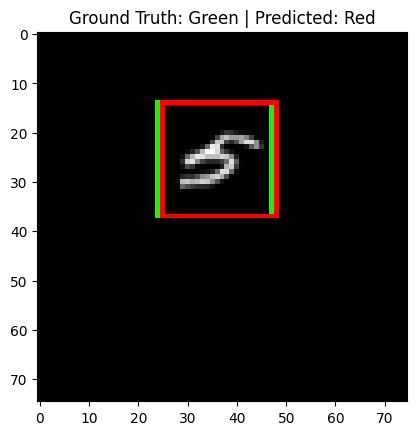

1/1 [==============================] - 0s 12ms/step


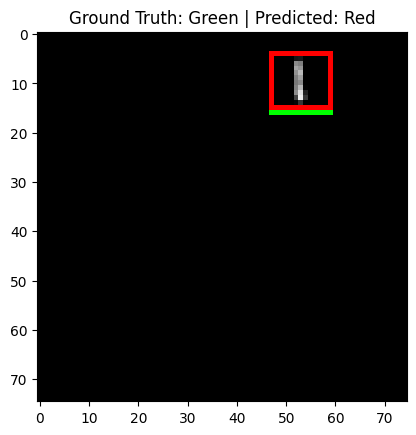

1/1 [==============================] - 0s 11ms/step


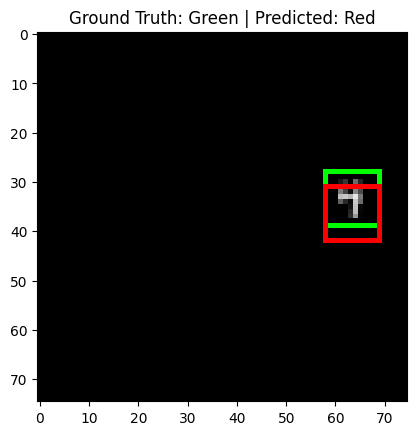

1/1 [==============================] - 0s 12ms/step


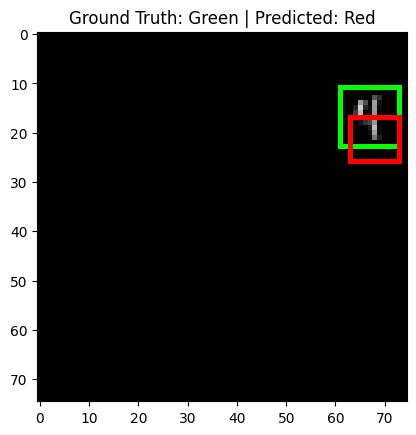

1/1 [==============================] - 0s 11ms/step


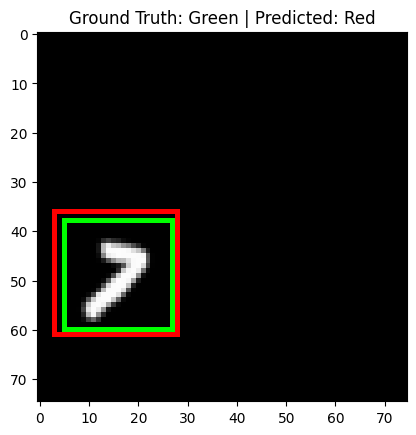

1/1 [==============================] - 0s 13ms/step


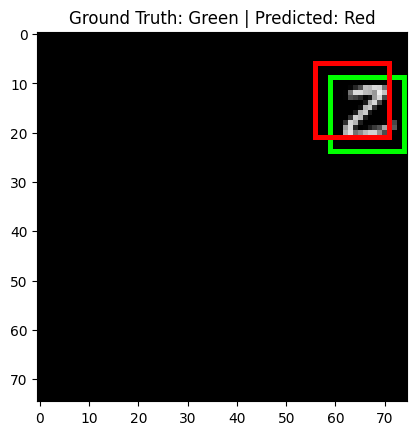

1/1 [==============================] - 0s 11ms/step


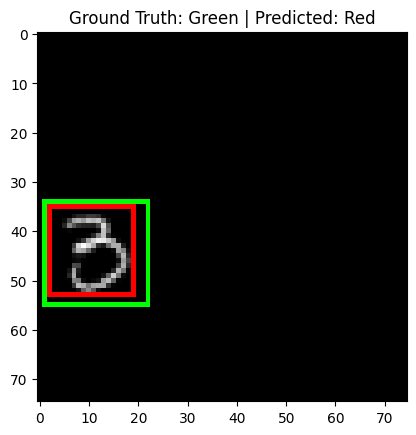

1/1 [==============================] - 0s 11ms/step


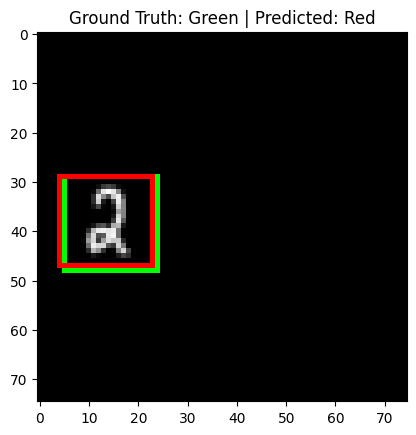

1/1 [==============================] - 0s 11ms/step


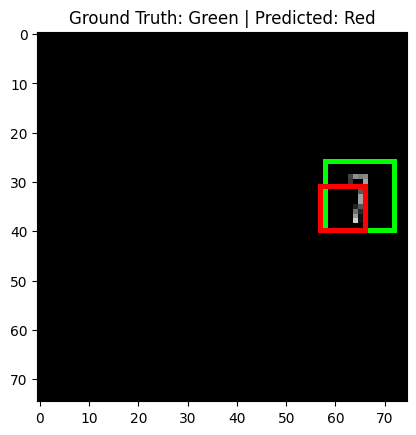

1/1 [==============================] - 0s 12ms/step


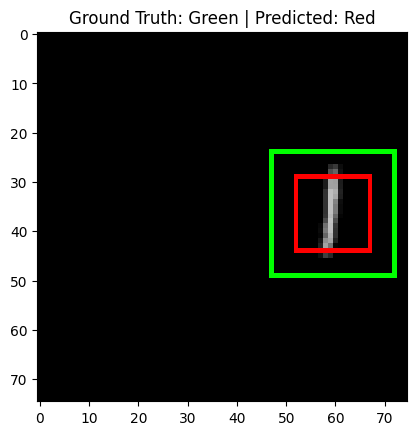

1/1 [==============================] - 0s 11ms/step


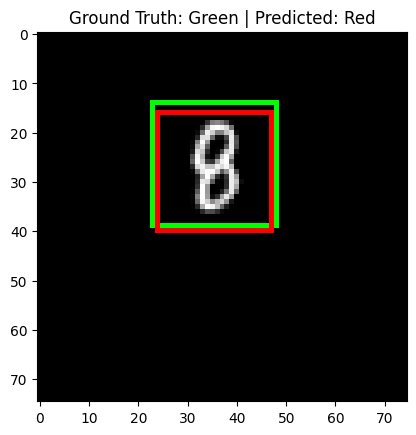

1/1 [==============================] - 0s 12ms/step


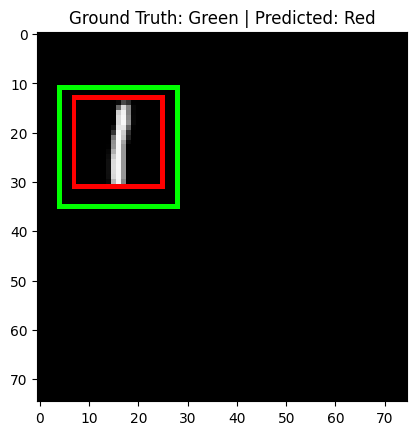

1/1 [==============================] - 0s 17ms/step


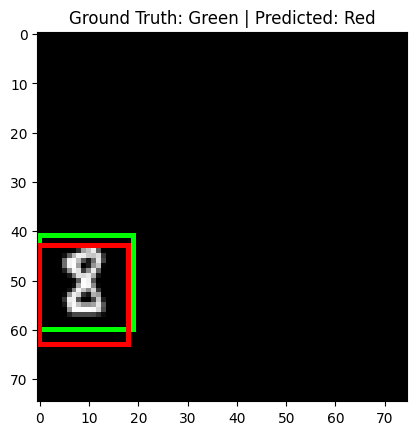

1/1 [==============================] - 0s 11ms/step


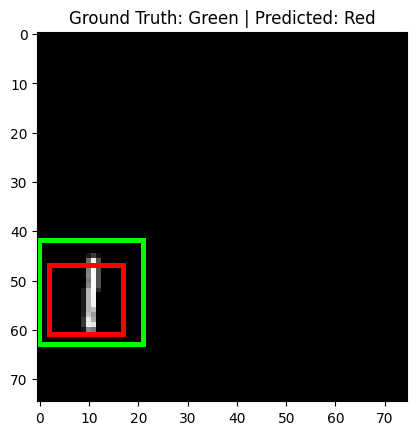

1/1 [==============================] - 0s 13ms/step


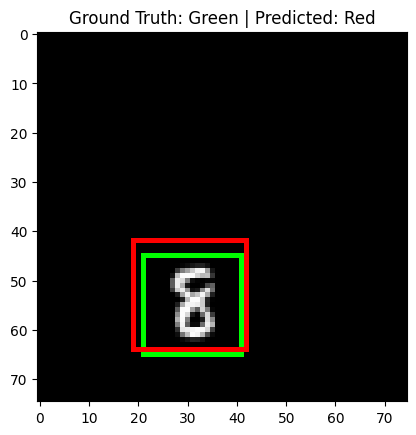

1/1 [==============================] - 0s 11ms/step


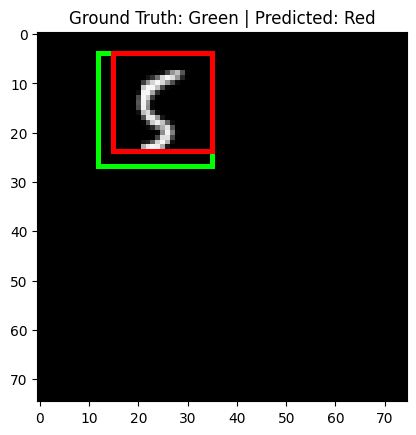

1/1 [==============================] - 0s 12ms/step


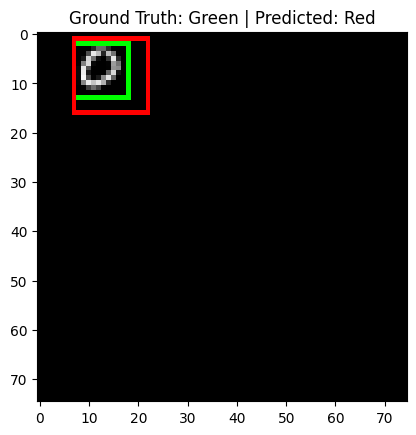

1/1 [==============================] - 0s 11ms/step


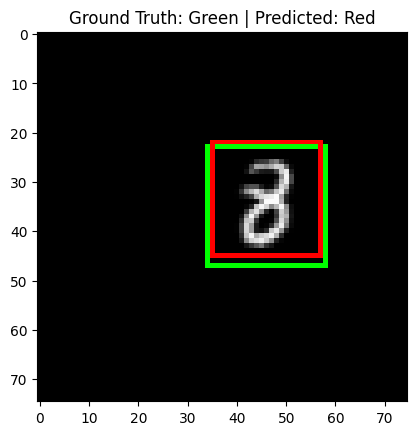

1/1 [==============================] - 0s 11ms/step


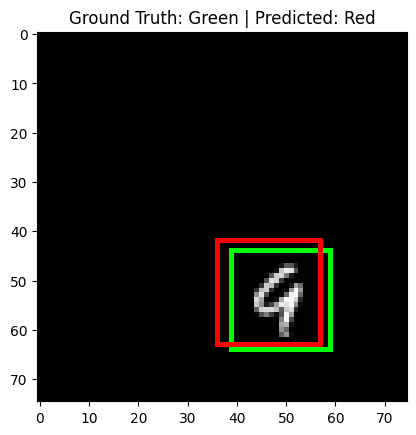

1/1 [==============================] - 0s 12ms/step


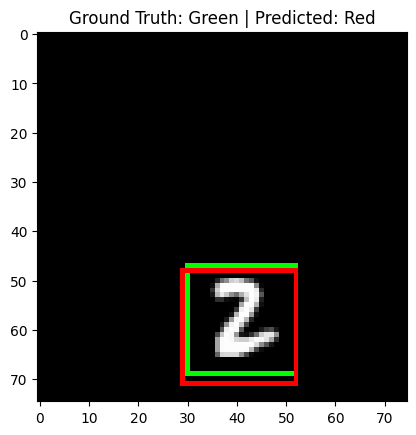

1/1 [==============================] - 0s 12ms/step


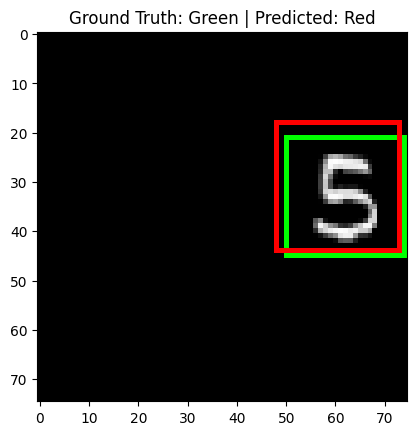

1/1 [==============================] - 0s 11ms/step


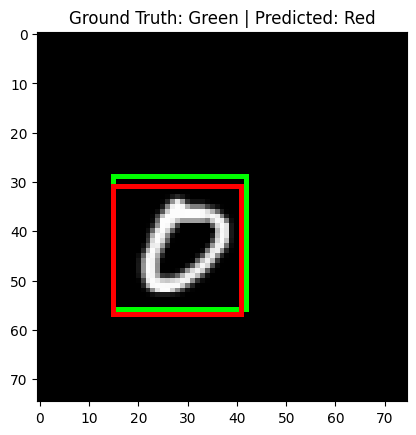

1/1 [==============================] - 0s 12ms/step


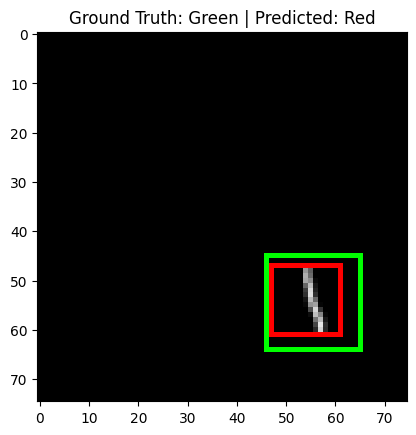

1/1 [==============================] - 0s 12ms/step


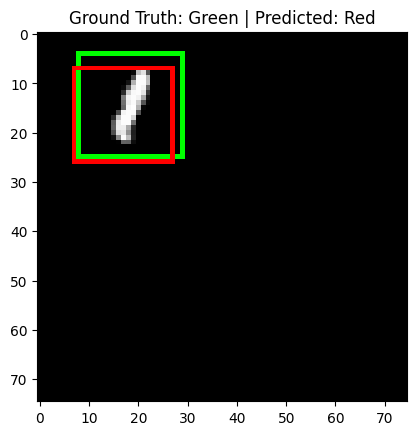

1/1 [==============================] - 0s 12ms/step


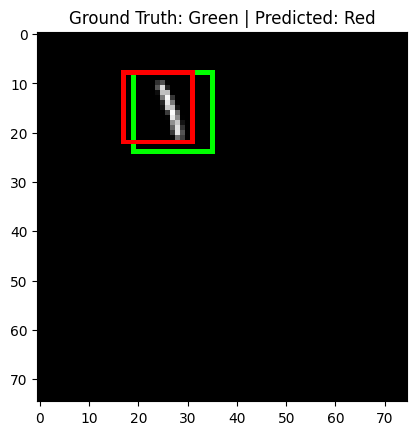

1/1 [==============================] - 0s 12ms/step


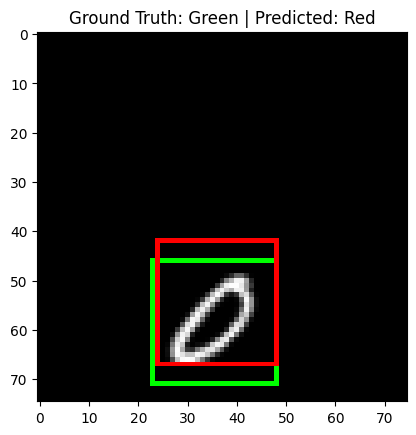

1/1 [==============================] - 0s 12ms/step


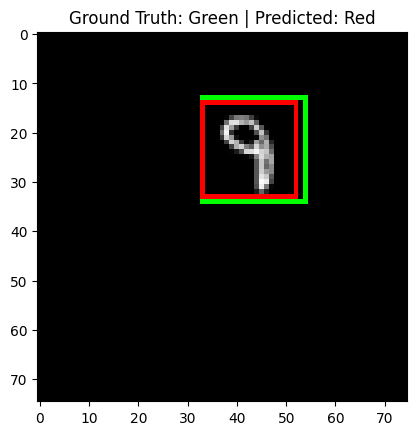

1/1 [==============================] - 0s 12ms/step


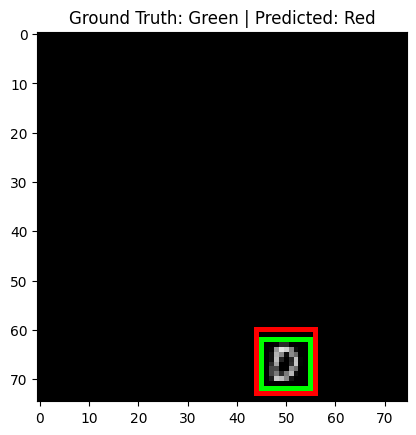

1/1 [==============================] - 0s 11ms/step


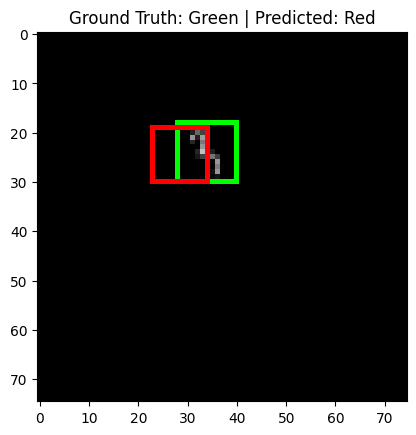

1/1 [==============================] - 0s 12ms/step


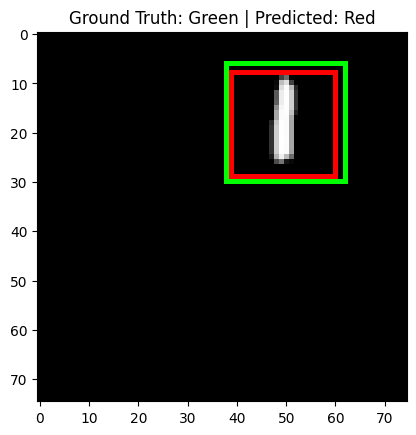

1/1 [==============================] - 0s 11ms/step


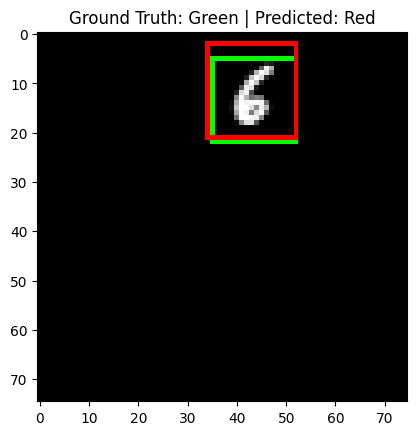

1/1 [==============================] - 0s 13ms/step


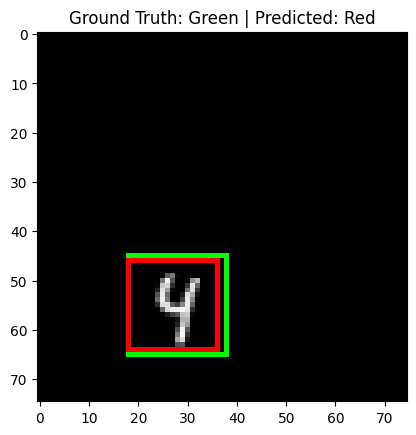

1/1 [==============================] - 0s 11ms/step


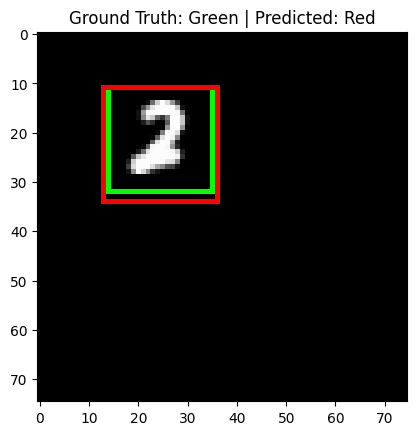

In [123]:
for i in range(100):
    index = 100 + i
    
    img = test_x[index].reshape(1,-1)

    pic = img.reshape(75,75) * 255
    pic = pic.astype(np.uint8)
    pic_rgb = cv2.cvtColor(pic, cv2.COLOR_GRAY2RGB)
    
    # Actual coordinates
    xmin,ymin,xmax,ymax = map(int,test_y[index])
    pic = cv2.rectangle(pic_rgb, (xmin,ymin), (xmax, ymax), (0,255,0) , 1)
    
    # predicted coordinates
    pred = model.predict(img)
    
    xmin,ymin,xmax,ymax = map(int,pred[0])
    pic = cv2.rectangle(pic_rgb, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)
    

    plt.imshow(pic, cmap='gray')
    plt.title("Ground Truth: Green | Predicted: Red")
    plt.show()
